In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image_dataset_from_directory

In [2]:
# Function to ensure dataset consistency
def ensure_consistent_batches(train_ds, val_ds):
    # Check and adjust train dataset
    number_of_train_batches = tf.data.experimental.cardinality(train_ds).numpy()
    number_of_val_batches = tf.data.experimental.cardinality(val_ds).numpy()

    print(f"Training batches: {number_of_train_batches}")
    print(f"Validation batches: {number_of_val_batches}")

    # Ensure both datasets have batches fully divisible by batch_size and aligned
    assert number_of_train_batches == number_of_val_batches, "Train and validation datasets have unaligned batch numbers!"

# Load and preprocess dataset
def create_dataset(rgb_dir, of_dir, batch_size=32, img_size=(224, 224), validation_split=None, subset=None):
    """
    Load and merge datasets from given directories for RGB and Optical Flow images.
    """
    preprocess = tf.keras.applications.mobilenet_v3.preprocess_input

    rgb_ds = image_dataset_from_directory(
        rgb_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,  # Originally batched here
        image_size=img_size,
        shuffle=True,
        seed=42,
        validation_split=validation_split,
        subset=subset,
        interpolation='bilinear',
        follow_links=False
    ).map(lambda x, y: (preprocess(x), y))

    of_ds = image_dataset_from_directory(
        of_dir,
        labels='inferred',
        label_mode='categorical',
        class_names=None,
        color_mode='rgb',
        batch_size=batch_size,  # Originally batched here
        image_size=img_size,
        shuffle=True,
        seed=42,
        validation_split=validation_split,
        subset=subset,
        interpolation='bilinear',
        follow_links=False
    ).map(lambda x, y: (preprocess(x), y))

    # Ensure batches are the same size by applying drop_remainder=True
    rgb_ds = rgb_ds.unbatch().batch(batch_size, drop_remainder=True)
    of_ds = of_ds.unbatch().batch(batch_size, drop_remainder=True)

    # Zip datasets together
    return tf.data.Dataset.zip((rgb_ds, of_ds)).map(lambda x, y: ((x[0], y[0]), y[1]))

In [3]:
def rename_model_layers(model, prefix):
    """
    Rename all layers in a given model with a specified prefix.
    """
    for layer in model.layers:
        layer._name = f'{prefix}_{layer.name}'
    return model

# Define and compile the model
def create_dual_stream_mobilenetv3(input_shape, num_classes):
    """
    Creates a dual-stream MobileNetV3Small architecture for handling both RGB and Optical Flow inputs.
    """
    # Base model for RGB data
    rgb_input = Input(shape=input_shape, name='rgb_input')
    rgb_base_model = MobileNetV3Small(include_top=False, input_tensor=rgb_input, weights='imagenet')
    rgb_base_model = rename_model_layers(rgb_base_model, 'rgb')

    # Base model for Optical Flow data
    of_input = Input(shape=input_shape, name='of_input')
    of_base_model = MobileNetV3Small(include_top=False, input_tensor=of_input, weights='imagenet')
    of_base_model = rename_model_layers(of_base_model, 'of')

    # Ensure GlobalAveragePooling is applied to collapse the spatial dimensions
    rgb_features = GlobalAveragePooling2D()(rgb_base_model.output)
    of_features = GlobalAveragePooling2D()(of_base_model.output)

    # Concatenate the features from both streams
    concatenated_features = Concatenate()([rgb_features, of_features])

    # Dense layer for classification
    x = Dense(512, activation='relu')(concatenated_features)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation='softmax')(x)  # Ensure the output matches the number of classes

    # Construct and compile the model
    model = Model(inputs=[rgb_input, of_input], outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [4]:
# Directory locations
rgb_dir = 'kaggle-dataset-6classes-preprocessed/frames/trainval'
of_dir = 'kaggle-dataset-6classes-preprocessed/of/trainval'
test_rgb_dir = 'kaggle-dataset-6classes-preprocessed/frames/test'
test_of_dir = 'kaggle-dataset-6classes-preprocessed/of/test'

In [5]:
# Parameters
batch_size = 32
img_size = (224, 224)
validation_split = 0.2

# Create datasets
train_ds = create_dataset(rgb_dir, of_dir, batch_size=batch_size, img_size=img_size, validation_split=validation_split, subset='training')
val_ds = create_dataset(rgb_dir, of_dir, batch_size=batch_size, img_size=img_size, validation_split=validation_split, subset='validation')
test_ds = create_dataset(test_rgb_dir, test_of_dir, batch_size=batch_size, img_size=img_size)

Found 81089 files belonging to 7 classes.
Using 64872 files for training.
Found 80054 files belonging to 7 classes.
Using 64044 files for training.
Found 81089 files belonging to 7 classes.
Using 16217 files for validation.
Found 80054 files belonging to 7 classes.
Using 16010 files for validation.
Found 35114 files belonging to 7 classes.
Found 34649 files belonging to 7 classes.


In [6]:
# Model Parameters
IMG_SHAPE = (224, 224, 3)
N_CLASSES = 7

# Instantiate and compile the model
model = create_dual_stream_mobilenetv3(IMG_SHAPE, N_CLASSES)

In [7]:
# Example usage: iterate over the dataset
for (rgb_images, of_images), labels in train_ds.take(1):
    print(rgb_images.shape)  # Check shape of the RGB images
    print(of_images.shape)  # Check shape of the Optical Flow images
    print(labels.shape)     # Check shape of the labels

(32, 224, 224, 3)
(32, 224, 224, 3)
(32, 7)


In [8]:
# Training Callbacks
es = EarlyStopping(monitor='val_loss', patience=10, verbose=1)
mc = ModelCheckpoint('best_handwashing_model.h5', monitor='val_accuracy', save_best_only=True, verbose=1)

In [9]:
# Train the model
history = model.fit(train_ds, epochs=20, validation_data=val_ds, callbacks=[es, mc])

Epoch 1/20
   2001/Unknown - 4325s 2s/step - loss: 0.2829 - accuracy: 0.8987
Epoch 1: val_accuracy improved from -inf to 0.93625, saving model to best_handwashing_model.h5


ValueError: Unable to create dataset (name already exists)

In [12]:
def debug_dataset(ds):
    for (rgb_images, of_images), labels in ds.take(1):
        print("RGB images shape:", rgb_images.shape)  # Shape of the RGB images batch
        print("OF images shape:", of_images.shape)    # Shape of the Optical Flow images batch
        print("Labels shape:", labels.shape)          # Shape of the labels batch

# Debug the datasets
print("Training Dataset:")
debug_dataset(train_ds)
print("Validation Dataset:")
debug_dataset(val_ds)


Training Dataset:
RGB images shape: (32, 224, 224, 3)
OF images shape: (32, 224, 224, 3)
Labels shape: (32, 7)
Validation Dataset:
RGB images shape: (32, 224, 224, 3)
OF images shape: (32, 224, 224, 3)
Labels shape: (32, 7)


In [10]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

1082/1082 [==============================] - 256s 233ms/step - loss: 0.4178 - accuracy: 0.8555
Test Loss: 0.4177675247192383
Test Accuracy: 0.8555048704147339


1/1 [==============================] - 0s 477ms/step


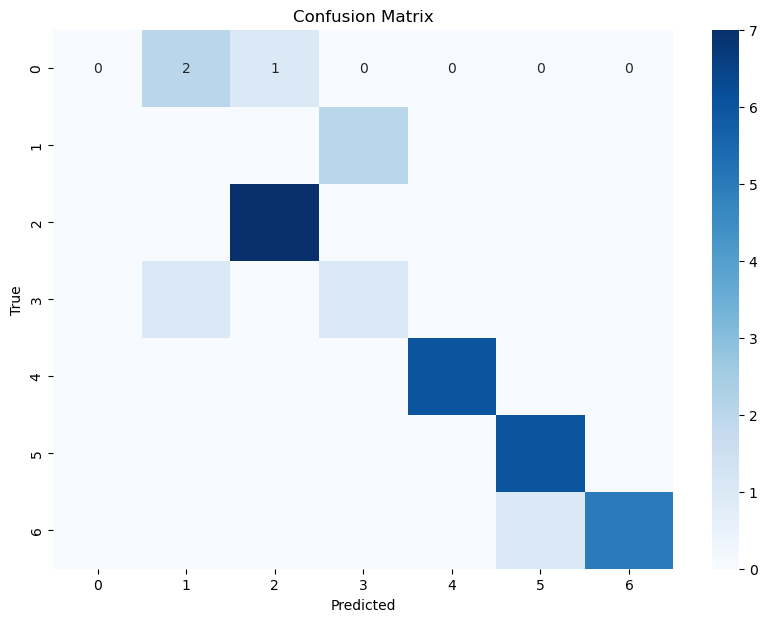

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Function to predict and return confusion matrix
def predict_and_visualize(model, dataset):
    images, labels = next(iter(dataset))  # Get one batch of test data
    predictions = model.predict(images)  # Predict
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = np.argmax(labels, axis=1)
    
    # Generate confusion matrix
    cm = confusion_matrix(true_classes, predicted_classes)
    return images, labels, cm, true_classes, predicted_classes

# Plotting confusion matrix
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Assuming you have your class names as a list of strings
class_names = [str(i) for i in range(7)]  # Update this with your actual class names if available

# Predict and visualize
images, labels, cm, true_classes, predicted_classes = predict_and_visualize(model, test_ds)
plot_confusion_matrix(cm, class_names)

In [12]:
# Print classification report for detailed metrics
print(classification_report(true_classes, predicted_classes, target_names=class_names))

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         3
           1       0.40      1.00      0.57         2
           2       0.80      0.80      0.80         5
           3       0.50      0.33      0.40         3
           4       1.00      0.80      0.89         5
           5       0.70      1.00      0.82         7
           6       1.00      0.29      0.44         7

    accuracy                           0.72        32
   macro avg       0.74      0.75      0.68        32
weighted avg       0.80      0.72      0.69        32


TypeError: Invalid shape (32, 224, 224, 3) for image data

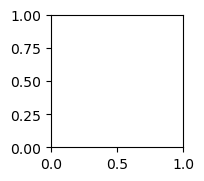

In [16]:
def display_sample_predictions(images, true_labels, predictions, class_names):
    plt.figure(figsize=(12, 10))
    for i in range(10):  # Display the first 10 images from the dataset
        plt.subplot(5, 2, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Actual: {class_names[true_labels[i]]}, Predicted: {class_names[predictions[i]]}")
        plt.axis("off")
    plt.show()

# Use the previous outputs to visualize sample predictions
display_sample_predictions(images, true_classes, predicted_classes, class_names)
